# Downloading Dataset

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sunny7712","key":"f59af526f9ec5fc5f75e10ffa0cb9efb"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d forderation/breakhis-400x
!unzip breakhis-400x

100% 799M/803M [00:05<00:00, 159MB/s]
100% 803M/803M [00:05<00:00, 149MB/s]
Archive:  breakhis-400x.zip
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png  
  inflating: BreaKHis 400X/test/

# Importing Dependencies

In [4]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2

# Understanding the Data

In [5]:
path = os.path.join(os.getcwd(), 'BreaKHis 400X')
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'test')

In [6]:
#Getting class labels

class_labels = []

for dir in os.listdir(train_path):
    class_labels.append(dir)

class_labels

['benign', 'malignant']

In [7]:
number_of_images_per_category = {}

for cat in os.listdir(train_path):
    number_of_images_per_category[cat] = len(os.listdir(os.path.join(train_path, cat)))

number_of_images_per_category    

{'benign': 371, 'malignant': 777}

In [8]:
img_array = cv2.imread(os.path.join(train_path, 'malignant', 'SOB_M_DC-14-10926-400-006.png'))
img_array.shape

(460, 700, 3)

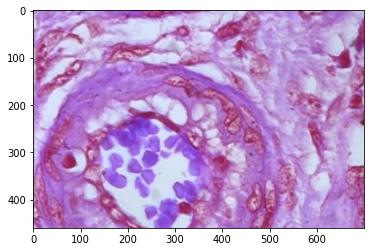

In [9]:
plt.imshow(img_array)

# Loading Data and Augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
img_size = 224
batch_size = 32

In [24]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    horizontal_flip = True,
    fill_mode = 'nearest'
    
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb'

)

val_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb'
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


# Model

In [26]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## VGG16

In [34]:
vgg16_base = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

In [35]:
vgg_model = Sequential()
vgg_model.add(vgg16_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(1, activation = 'sigmoid'))

In [36]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 2

In [37]:
vgg16_base.trainable = False

In [38]:
vgg_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [39]:
vgg_history = vgg_model.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
36/36 [==============================] - 50s 1s/step - loss: 1.4752 - accuracy: 0.5976 - precision_4: 0.6928 - recall_4: 0.7284 - auc_4: 0.5369 - val_loss: 0.6729 - val_accuracy: 0.5725 - val_precision_4: 0.9198 - val_recall_4: 0.4038 - val_auc_4: 0.7992
Epoch 2/30
36/36 [==============================] - 37s 1s/step - loss: 0.6890 - accuracy: 0.6533 - precision_4: 0.7122 - recall_4: 0.8185 - auc_4: 0.5942 - val_loss: 0.5509 - val_accuracy: 0.7450 - val_precision_4: 0.7614 - val_recall_4: 0.9079 - val_auc_4: 0.8100
Epoch 3/30
36/36 [==============================] - 35s 969ms/step - loss: 0.6350 - accuracy: 0.6629 - precision_4: 0.7074 - recall_4: 0.8559 - auc_4: 0.6145 - val_loss: 0.5563 - val_accuracy: 0.6789 - val_precision_4: 0.6810 - val_recall_4: 0.9892 - val_auc_4: 0.8274
Epoch 4/30
36/36 [==============================] - 35s 974ms/step - loss: 0.5279 - accuracy: 0.7404 - precision_4: 0.7700 - recall_4: 0.8790 - auc_4: 0.7654 - val_loss: 0.5377 - val_accuracy: 0.7064

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'auc_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4', 'val_auc_4'])


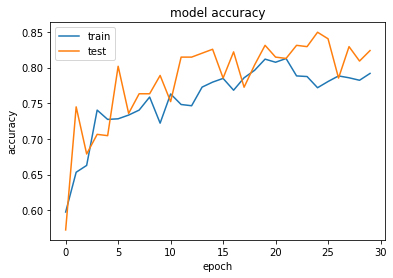

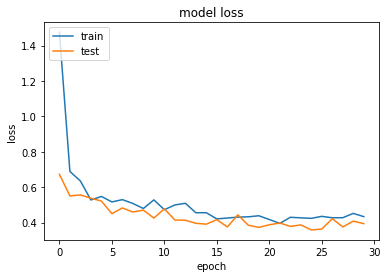

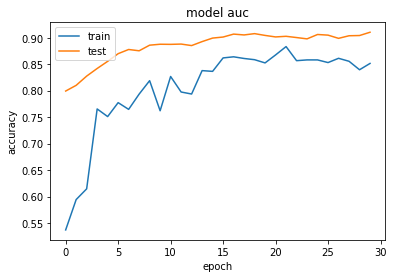

In [43]:
print(vgg_history.history.keys())
# summarize history for accuracy
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(vgg_history.history['auc_4'])
plt.plot(vgg_history.history['val_auc_4'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Xception

In [44]:
xception_base = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

83683744/83683744 [==============================] - 1s 0us/step


In [45]:
xception_model = Sequential()
xception_model.add(xception_base)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation = 'relu'))
xception_model.add(Dropout(0.3))
xception_model.add(Dense(256, activation = 'relu'))
xception_model.add(Dropout(0.3))
xception_model.add(Dense(1, activation = 'sigmoid'))

In [47]:
xception_base.trainable = False

In [48]:
xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [49]:
xception_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [50]:
xception_history = xception_model.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
36/36 [==============================] - 43s 1s/step - loss: 5.2268 - accuracy: 0.5906 - precision_5: 0.7028 - recall_5: 0.6847 - auc_5: 0.5410 - val_loss: 0.6229 - val_accuracy: 0.6844 - val_precision_5: 0.7494 - val_recall_5: 0.8022 - val_auc_5: 0.6742
Epoch 2/30
36/36 [==============================] - 36s 1s/step - loss: 1.4535 - accuracy: 0.6254 - precision_5: 0.7222 - recall_5: 0.7259 - auc_5: 0.6111 - val_loss: 0.5861 - val_accuracy: 0.7028 - val_precision_5: 0.7401 - val_recall_5: 0.8645 - val_auc_5: 0.7343
Epoch 3/30
36/36 [==============================] - 36s 1s/step - loss: 0.9753 - accuracy: 0.6638 - precision_5: 0.7447 - recall_5: 0.7658 - auc_5: 0.6582 - val_loss: 0.5596 - val_accuracy: 0.7193 - val_precision_5: 0.7213 - val_recall_5: 0.9539 - val_auc_5: 0.7683
Epoch 4/30
36/36 [==============================] - 36s 1s/step - loss: 0.8189 - accuracy: 0.6707 - precision_5: 0.7472 - recall_5: 0.7761 - auc_5: 0.6840 - val_loss: 0.5597 - val_accuracy: 0.6991 - val

## AlexNet

In [51]:
img_size = 227
batch_size = 32

In [52]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    horizontal_flip = True,
    fill_mode = 'nearest'
    
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [53]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb'

)

val_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'rgb'
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [55]:
alex = Sequential()
alex.add(Conv2D(96, (11, 11), strides= 4, padding= 'valid', activation= 'relu', input_shape=(img_size, img_size, 3), kernel_initializer= 'he_normal'))
alex.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid'))
alex.add(Conv2D(256, kernel_size=(5,5), strides= 1, padding= 'same', activation= 'relu', kernel_initializer= 'he_normal')) 
alex.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid'))
alex.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'))
alex.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'))
alex.add(Conv2D(256, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'))
alex.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid'))

alex.add(Flatten())
alex.add(Dense(4096, activation= 'relu'))
alex.add(Dense(4096, activation= 'relu'))
alex.add(Dense(1000, activation= 'relu'))
alex.add(Dense(1, activation= 'sigmoid'))

In [56]:
alex.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)      

In [57]:
alex.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [59]:
alex_history = alex.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
36/36 [==============================] - 39s 929ms/step - loss: 11.1589 - accuracy: 0.6603 - precision_6: 0.6817 - recall_6: 0.9344 - auc_6: 0.4920 - val_loss: 0.6201 - val_accuracy: 0.6771 - val_precision_6: 0.6771 - val_recall_6: 1.0000 - val_auc_6: 0.6767
Epoch 2/30
36/36 [==============================] - 33s 923ms/step - loss: 0.6151 - accuracy: 0.6768 - precision_6: 0.6768 - recall_6: 1.0000 - auc_6: 0.6418 - val_loss: 0.6221 - val_accuracy: 0.6220 - val_precision_6: 0.8468 - val_recall_6: 0.5393 - val_auc_6: 0.7772
Epoch 3/30
36/36 [==============================] - 32s 899ms/step - loss: 0.5810 - accuracy: 0.6890 - precision_6: 0.7000 - recall_6: 0.9459 - auc_6: 0.7138 - val_loss: 0.4942 - val_accuracy: 0.8165 - val_precision_6: 0.8305 - val_recall_6: 0.9160 - val_auc_6: 0.7869
Epoch 4/30
36/36 [==============================] - 33s 914ms/step - loss: 0.4911 - accuracy: 0.7901 - precision_6: 0.7991 - recall_6: 0.9215 - auc_6: 0.8005 - val_loss: 0.4774 - val_accuracy:

dict_keys(['loss', 'accuracy', 'precision_6', 'recall_6', 'auc_6', 'val_loss', 'val_accuracy', 'val_precision_6', 'val_recall_6', 'val_auc_6'])


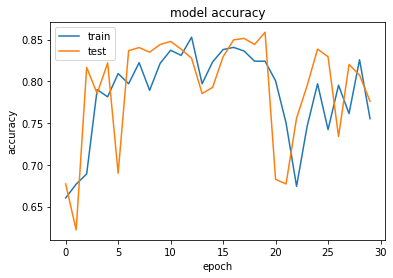

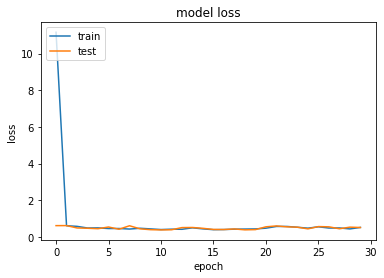

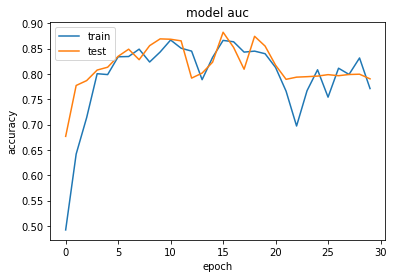

In [61]:
print(alex_history.history.keys())
# summarize history for accuracy
plt.plot(alex_history.history['accuracy'])
plt.plot(alex_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(alex_history.history['loss'])
plt.plot(alex_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(alex_history.history['auc_6'])
plt.plot(alex_history.history['val_auc_6'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()